# Assigment 1, part3  
Link to github : https://github.com/HugoCote/Assignment-1-Part-3/


In [357]:
import torch
import torchvision

# we use torch.cuda.Event(enable_timing=True) to measure time
# from timeit import default_timer as timer
# import time

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy                  # for copy.deepcopy( ... )

import matplotlib.pyplot as plt
import numpy as np

from __future__ import print_function, division
import os
from PIL import Image
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import collections
from collections import OrderedDict
import torch.nn.init as init

import datetime                      # to include date in log file name

import sobol_seq # for parameter search
import math # for ceiling function
# the following command line produces sound and is used after cells that 
# require more time to execute :
import IPython.display # to display .png

from IPython.display import Audio
wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 

### Import the data used for training and validation  
And instantiate two datasets, one with and one without data augmentation

In [358]:
random_seed= 2019
batch_size = 8
validation_split = .10
shuffle_dataset = True
num_workers = 0        # dataloader issues with numworkers > 0

# used to scale tensor from [0 to 1] to [0 to 255]
# Without this, with the hyper-parameters tested, the models stay at 50% accuracy
def multby255 (pic) :
    return pic.mul(255)

# setting up data loader
root = './data_catdogs/trainset/'

# different ways to augment the data
data_transforms = {
    'high': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(90, scale=(0.80, 1.0), ratio=(0.75, 1.25), interpolation=2),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'medium': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(80, scale=(0.85, 1.0), ratio=(0.8, 1.2), interpolation=2),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'low': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'normal': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ])
}

# to be able to train and valide on both the original and the augmented dataset
train_dataset_augm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["medium"])
train_dataset_norm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["normal"])

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset_augm)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# 
batch_size = 32
train_norm_loader = DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
train_augm_loader = DataLoader(train_dataset_augm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_norm_loader = DataLoader(train_dataset_norm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
valid_augm_loader = DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

#### Compute and display the size of each dataset

In [360]:
dummy_train_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=1, sampler=train_sampler, num_workers=0)
dummy_valid_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=1, sampler=valid_sampler, num_workers=0)
train_dataset_size  = dummy_train_loader.__len__()
valid_dataset_size   = dummy_valid_loader.__len__()
print("training   dataset size : " , train_dataset_size)
print("validation dataset size : " , valid_dataset_size)
del dummy_train_loader 
del dummy_valid_loader 

training   dataset size :  17999
validation dataset size :  1999


### Display some samples

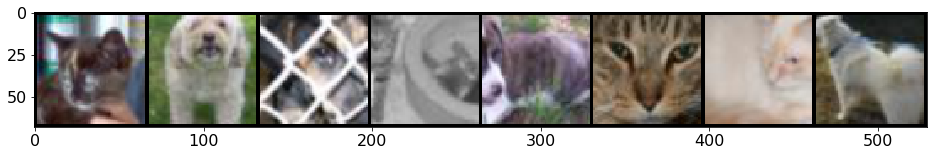

    0     1     1     0     1     0     0     1


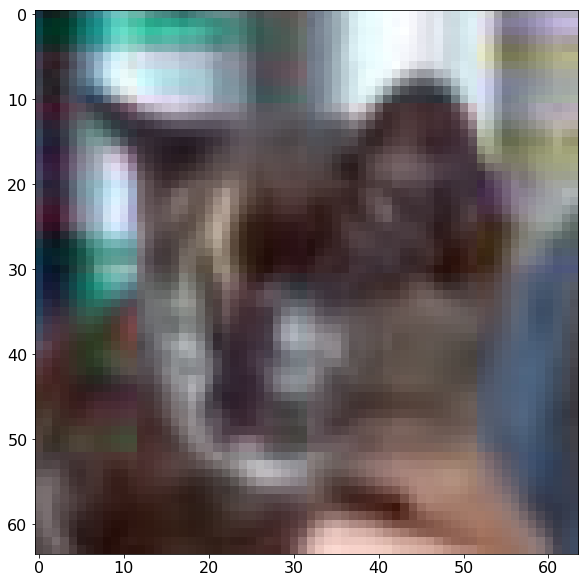

In [413]:
batch_size = 8
# picture_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
pict_n_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
pict_a_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

sz = 64
tosmaller = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(sz),
                transforms.ToTensor(),
                transforms.Lambda(multby255)
            ])

# functions to show an image

def imshow(img):
    npimg = img.numpy()  / 255
    # npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(pict_a_loader) :
    if i > 0 : break

    # show images
    imshow(torchvision.utils.make_grid(images ))
    # print labels
    print(' '.join('%5s' % labels[j].item() for j in range(min(batch_size,8))))
    sample_image = images[0]

imshow(torchvision.utils.make_grid( sample_image ))

## Set the device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## The models

In [6]:
class MLP(nn.Module):
    def __init__(self, h1, h2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*64*64, h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.fc3 = nn.Linear(h2 , 1)

    def forward(self, x):
        x = x.view( -1, 3*64*64 )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Architecture of Classifier taken from : https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [7]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz = 3 ):
        
        if kernel_sz % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad = kernel_sz // 2 
        
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz , kernel_sz ), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.fct = nn.Linear(4*4*128, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fct(x)
        return x

In [8]:
class Classifier1(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz1 = 9, kernel_sz2 = 3 ):
        
        if kernel_sz1 % 2 == 0 or kernel_sz2 % 2 == 0:
            raise ValueError("kernel size must be odd")
        pad1 = kernel_sz1 // 2 
        pad2 = kernel_sz2 // 2 
        
        super(Classifier1, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, feature map size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz1 , kernel_sz1 ), padding=pad1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, feature map size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz1 , kernel_sz1), padding=pad1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, feature map size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz1 , kernel_sz1), padding=pad1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4, feature map size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(kernel_sz2 , kernel_sz2), padding=pad2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5, feature map size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(kernel_sz2 , kernel_sz2), padding=pad2),
            nn.ReLU(),
        )
        # 
        self.fct1 = nn.Linear(4*4*256, 1024)
        self.fct2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = self.fct1(x)
        x = F.softmax(self.fct2(x),dim=-1)
        return x

In [9]:
class Classifier1b(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz1=13 , kernel_sz2=11, regression = 800, sigmoid=False ):
        
        self.sigmoid = sigmoid
        if kernel_sz1 % 2 == 0 or kernel_sz2 % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad1 = kernel_sz1 // 2 
        pad2 = kernel_sz2 // 2 
        
        super(Classifier1b, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz1 , kernel_sz1 ), padding=pad1 ),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 64^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz2 , kernel_sz2), padding=pad2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer intermediaire, input size = 32^2, output size 14^2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=( 10 , 10), padding=2,  stride = 2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 14^2, output size 4^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( 3 , 3 ), padding = 0, stride = 3),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),     
        )
        
        # Regression
        self.clf1 = nn.Linear(4*4*64, regression)
        self.clf2 = nn.Linear(regression, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        if self.sigmoid :
            x = torch.tanh(x)
        x = self.clf1(x)
        x = self.clf2(x)
        return x

In [10]:
class Classifier1c(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz1=9 , kernel_sz2=9, sigmoid=False ):
        
        self.sigmoid = sigmoid
        if kernel_sz1 % 2 == 0 or kernel_sz2 % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad1 = kernel_sz1 // 2 
        pad2 = kernel_sz2 // 2
        
        stride1 = 1
        stride2 = 1
        
        super(Classifier1c, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=( kernel_sz1 , kernel_sz1 ), padding=pad1, stride=stride1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 64^2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=( kernel_sz2 , kernel_sz2), padding=pad2, stride=stride2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 64^2, output size = 8^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( 37 , 37 ), padding=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 8^2, output size 2^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( 3 , 3 ), padding = 1, stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)     
        )
        
        # Regression
        self.clf = nn.Linear(2*2*64, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        if self.sigmoid :
            x = torch.tanh(x)
        x = self.clf(x)
        return x

In [11]:
class Classifier2(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([11,9,9,7,3,3])
        pad = kernel_sz // 2 
        pad[4] = 0
        
        super(Classifier2, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct1 = nn.Linear(512, 512)
        self.fct2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x

taken from :  
https://medium.com/@harsathAI/cats-and-dogs-classifier-convolutional-neural-network-with-python-and-tensorflow-9-steps-of-6259c92802f3

In [12]:
class Classifier3(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,5,3,3])
        # kernel_sz = np.array([3,3,3,3,3,3])
        pad = kernel_sz // 2 
        # pad[4] = 0
        
        super(Classifier3, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct = nn.Linear(8*8*256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,8*8*256)
        x = self.fct(x)
        return x

In [13]:
class Classifier4(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,5,3,3])
        pad = kernel_sz // 2 
        pad[5] = 0
        
        super(Classifier4, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct1 = nn.Linear(1*1*512, 512)
        self.fct2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x

In [14]:
class Classifier5(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        super(Classifier5, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)           
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = self.fct1b(x)
        return x

In [15]:
class Classifier5b(nn.Module):
    """Convnet Classifier"""
    def __init__(self , sigmoid = True):
        
        self.sigmoid = sigmoid
        kernel_sz = np.array([11,9,7,5,3,3,3])
        pad = kernel_sz // 2 
        pad[6] = 0 
        
        super(Classifier5b, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 64^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 64^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 32^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 5, input size = 16^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6, input size = 8^2
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7, input size = 4^2, output size = 1^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
            
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        if self.sigmoid :
            x = torch.tanh(x)
        x = self.fct1b(x)
        return x

In [16]:
class Classifier5c(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3])
        pad = kernel_sz // 2 
        
        super(Classifier5c, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5, input size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6, input size = 2^2
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
            
        )
        # 
        self.fct1 = nn.Linear(1*1*256, 256)
        self.fct2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*256)
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x

In [17]:
class Classifier5d(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        super(Classifier5d, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.relu(self.fct1b(x))
        x = F.softmax(x,dim=-1)
        return x

In [18]:
class Classifier6(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([11,9,7,3,3,3,3,3,2])
        pad = kernel_sz // 2 
        pad[8] = 0 
        
        super(Classifier6, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, feature map size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, feature map size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, feature map size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),

            # Layer 4, feature map size = 16^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),

            # Layer 5, feature map size = 16^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            
            # Layer 6, feature map size = 16^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7, feature map size = 8^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 8, feature map size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[7], kernel_sz[7]) , padding=pad[7]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 9, feature map size = 2^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[8], kernel_sz[8]) , padding=pad[8])    
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = self.fct1b(x)
        return x

Print the number of parameters in each models and display the computation 

In [19]:
def number_of_params( net , display_comp = False ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1
            
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    if display_comp: 
        print( "number of params = " , nb_param , " = ", param_lst  )
        
    return nb_param, depth
  

In [20]:
import torchvision.models # for vgg16

list_of_models = [ 
    torchvision.models.vgg16( pretrained=False, num_classes=2, init_weights=False ),
    MLP(620,620),
    Classifier(3),
    Classifier5(),
    Classifier5b()
]
for net in list_of_models:
    print( net.__doc__ )
    _ , _ = number_of_params( net , display_comp = True )

None
number of params =  134268738  =   
 (features.0.weight)      64*3*3*3
 (features.0.bias)      + 64
 (features.2.weight)    + 64*64*3*3
 (features.2.bias)      + 64
 (features.5.weight)    + 128*64*3*3
 (features.5.bias)      + 128
 (features.7.weight)    + 128*128*3*3
 (features.7.bias)      + 128
 (features.10.weight)   + 256*128*3*3
 (features.10.bias)     + 256
 (features.12.weight)   + 256*256*3*3
 (features.12.bias)     + 256
 (features.14.weight)   + 256*256*3*3
 (features.14.bias)     + 256
 (features.17.weight)   + 512*256*3*3
 (features.17.bias)     + 512
 (features.19.weight)   + 512*512*3*3
 (features.19.bias)     + 512
 (features.21.weight)   + 512*512*3*3
 (features.21.bias)     + 512
 (features.24.weight)   + 512*512*3*3
 (features.24.bias)     + 512
 (features.26.weight)   + 512*512*3*3
 (features.26.bias)     + 512
 (features.28.weight)   + 512*512*3*3
 (features.28.bias)     + 512
 (classifier.0.weight)  + 4096*25088
 (classifier.0.bias)    + 4096
 (classifier.3.

#### Test a model  
To see if it works and if its output has the required shape

In [ ]:
mynet = Classifier(3)
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
criterion = nn.CrossEntropyLoss()
want_to_test = True
if want_to_test:
    with torch.no_grad() :
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cudanet(inputs)
            loss = criterion(outputs, labels)
            print( outputs.size() , labels.size() )
            print( loss )
            break
del mynet

In [286]:
x = torch.rand(3,3)
print(x)

tensor([[0.7612, 0.6186, 0.0077],
        [0.8926, 0.0579, 0.1812],
        [0.2522, 0.8896, 0.8940]])


In [290]:
print(x.pow(2).sum())
print(x)

tensor(3.4495)
tensor([[0.7612, 0.6186, 0.0077],
        [0.8926, 0.0579, 0.1812],
        [0.2522, 0.8896, 0.8940]])


In [317]:
norm_L2 = torch.tensor(0.0, dtype = torch.float, device=device)
for param in net1.parameters() :
    if len(param.shape) == 1 : # skip biases
        continue
    norm_L2 += param.pow(2).sum()
norm_L2 = torch.sqrt(norm_L2)
print(norm_L2)

tensor(29.9896, device='cuda:0', grad_fn=<SqrtBackward>)


# Training  
training algorithm below

In [362]:
# make sound once done, should only be used to wrap a function that returns nothing 
def make_sound(func):
    def wrapper_make_sound(*args, **kwargs):
        func(*args, **kwargs)
        wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 
        audio = Audio(wave, rate=10000, autoplay=True)
        return audio
    return wrapper_make_sound

# measure time with cuda events
def display_timer(func):
    def wrapper_display_timer(*args, **kwargs):
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end   = torch.cuda.Event(enable_timing=True)
        start.record()
        res = func(*args, **kwargs)
        end.record()
        torch.cuda.synchronize()
        print( "Time required = " , start.elapsed_time(end)*0.001 , " s ")
        return res
    return wrapper_display_timer

@make_sound
@display_timer
def fake_training_phase( net, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, valid_loader, state_dict_list ):
    pass
    
@make_sound
@display_timer
def training_phase( net, nb_epoch, optimizer, regul, patience, avg_loss, accuracy, train_loader, valid_loader, state_dict_list ):
    
    criterion_sum = nn.CrossEntropyLoss(reduction='sum')
    criterion     = nn.CrossEntropyLoss() 
    max_valid_acc      = 50
    waiting_period     = 0
    abandon_train      = False
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times

        running_loss  = torch.tensor([0], dtype=torch.float, device = device) 
        correct       = torch.tensor([0], device = device)
        total         = torch.tensor([0], device = device) 
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs).squeeze()
            
            norm_L2 = torch.tensor(0.0, dtype = torch.float, device=device)
            for param in net.parameters() :
                if len(param.shape) == 1 : # skip biases
                    continue
                norm_L2 += param.pow(2).sum()
            norm_L2 = torch.sqrt(norm_L2)
            
            loss = criterion(outputs, labels) + regul*norm_L2
            loss.backward()
            optimizer.step()

            # compute the correctness of the output labels
            with torch.no_grad() :
                _, predicted = torch.max(outputs.data, 1)
                total   += labels.size(0)
                correct += (predicted == labels).sum()
                loss_sum = criterion_sum(outputs, labels)

            # print statistics
            running_loss += loss_sum.item()
        else : # print every epoch
            avg_loss[epoch,0] = running_loss / total.float()
            accuracy[epoch,0] = 100 * correct.float() / total.float()
            
            valid_acc, valid_loss = measure_single_accuracy_and_loss(net, valid_loader, criterion_sum )
            avg_loss[epoch,1] = valid_loss
            accuracy[epoch,1] = valid_acc
            if valid_acc > max_valid_acc: # found new best accuracy
                max_valid_acc = valid_acc
                waiting_period= 0
            else :
                waiting_period+=1
        
            print( 'epoch = %3d, train loss = %.6f , train accuracy = %3f , valid loss = %.6f , valid accuracy = %3f' 
                          % (epoch + 1, avg_loss[epoch,0], accuracy[epoch,0], avg_loss[epoch,1], accuracy[epoch,1] )
                 ) 
            # save the current model's state_dictionnary
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in net.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()   
            
            if waiting_period > patience : # too much time since the last improvement
                abandon_train = True
        if abandon_train :
            print('Early stopping')
            break
    else : 
        print('Finished Training')

# measure accuracy of a single net, returns the accuracy
def measure_single_accuracy_and_loss( net, loader, criterion ):
    accuracy = torch.tensor([0.0], dtype=torch.float, device=device)
    avg_loss = torch.tensor([0.0], dtype=torch.float, device=device)
    with torch.no_grad():
        correct = torch.tensor([0], device=device)
        total   = torch.tensor([0], device=device)
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images).squeeze()
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum()
            avg_loss+= loss.item()
        accuracy = 100 * correct.float() / total.float()
        avg_loss = avg_loss/total.float()
    return accuracy, avg_loss      


### Plotting  
plotting function

In [214]:
# display 2 plots, accuracy and loss across epoch, their .shape must be n x 2, 
# want_log indicates that user wants to save the plot to a file
# filename should not contains the extension of the file
def plot_1d_acc_and_loss(net, accuracy, loss, path_to_save, filename, 
                         net_name="",want_log = False, figsize = (16,10), font_size = 16 ):
    
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
    
    nb_epoch =  accuracy.size()[0]
    
    x = np.linspace(1, nb_epoch, nb_epoch)
    
    y1a = copy.deepcopy(accuracy[:,1]).cpu().numpy()
    y1b = copy.deepcopy(accuracy[:,0]).cpu().numpy()
    line1a_label = "accuracy on the validation set"
    line1b_label = "accuracy on the training   set"
    
    y2a = copy.deepcopy(loss[:,1]).cpu().numpy()
    y2b = copy.deepcopy(loss[:,0]).cpu().numpy()
    line2a_label = "avg loss on the validation set"
    line2b_label = "avg loss on the training   set"
    
    plt.subplot(2,1,1)

    plt.axhline(y=75,color="black")

    line1a, = plt.plot(x, y1a, "o-", label=line1a_label)
    line1a.set_dashes([2, 2])  # 2pt line, 2pt break

    line1b, = plt.plot(x, y1b, "x-", label=line1b_label)
    line1b.set_dashes([2, 2])  # 2pt line, 2pt break

    str_title1 = "Accuracy during the training"
    plt.title(str_title1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2,1,2)
    
    line2a, = plt.plot(x, y2a, "o-", label=line2a_label)
    line2a.set_dashes([2, 2])  # 2pt line, 2pt break

    line2b, = plt.plot(x, y2b, "x-", label=line2b_label)
    line2b.set_dashes([2, 2])  # 2pt line, 2pt break
    
    str_title1 = "Loss during the training"
    plt.title(str_title1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # ytop = ...
    # plt.ylim(0, ytop)     # set the ylim to bottom, top
    
    if net_name != "" :
        plt.suptitle(net_name, fontsize=font_size)
    
    # path_to_save = "./output/" 
    # filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
    if want_log :
        plt.savefig(path_to_save + filename + ".png")
    plt.show()

### Another ploting function  
This function takes an Nx1-array of number "accuracy", a Nx2-array "hyper_param".  
At position hyper_param[i,:] it shows a point which area is an increasing function of accuracy[i].  
The scaling depends on the content of accuracy and on the scaling parameter.   

In [349]:
def plot_accuracy_2d(accuracy,hyper_param,path_to_save,filename,title="",axis_label=("",""), want_log=False,scaling=(20,4)):
    x = hyper_param[:,0]
    y = hyper_param[:,1]

    N = hyper_param_sequence.__len__()
    val = accuracy
    val = val - val.min()
    val = val / val.max() 

    # colors = np.ones(N)*(0.2)
    area = scaling[0]*(1+val)**scaling[1]

    str_title1 = "Accuracy of CNN, trained using different hyper-parameters \n"
    str_title2 = "Accuracy range from {min:.{prec}f}%(area of {rmin:.{prec}f}) to {max:.{prec}f}%(area of {rmax:.{prec}f}) ".format(
          min  = _val.min(),
          rmin = area.min(),
          max  = _val.max(),
          rmax = area.max(),
          prec = 1
        )
    
    str_title = title
    if str_title :
        str_title = str_title + "\n"
    str_title = str_title + str_title1 + str_title2
    
    plt.title(str_title)
    plt.xlabel(axis_label[0])
    plt.ylabel(axis_label[1])
    
    xbot = x.min()
    xtop = x.max()
    xeps = (xtop-xbot)/100.0
    ybot = y.min()
    ytop = y.max()
    yeps = (ytop-ybot)/100.0
    
    plt.ylim(ybot-yeps, ytop+yeps)     # set the ylim to bottom, top
    plt.xlim(xbot-xeps, xtop+xeps)     # set the xlim to bottom, top
    
    plt.scatter(x, y, s=area)
    if want_log :
            plt.savefig(path_to_save + filename + ".png")   
    plt.show()

#### Initialization method  
We use glorot uniform initialization

In [278]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)

In [363]:
net1 = Classifier5()
net1.apply( glorot_init )  
_ = net1.to(device)

In [364]:
# define the loss function as the cross entropy and choose a learning rate that works well
# using no regularization :
# using low    data augmentation : lr = 0.0003392602539062500, batch size = 21
# using medium data augmentation : lr = 0.0005646362304687499, batch size = 18
# using high   data augmentation : lr = 0.0020221459960937504, batch size = 54
# using regularisation :
# using low    data augmentation : lr = 0.00908051           , batch size = 20, regul = 0.00971238 (lone)
# using low    data augmentation : lr = 0.00236848           , batch size = 20, regul = 0.00522644 (many)

lr = 0.00236848
optimizer      = optim.SGD(net1.parameters(), lr=lr, momentum=0.0, weight_decay=0)
patience       = 10
regularization = 0.00522644
nb_epoch  = 50

train_batch_size = 1 *20
valid_batch_size = 16*64
train_loader = DataLoader(train_dataset_augm, batch_size=train_batch_size,sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(train_dataset_norm, batch_size=valid_batch_size,sampler=valid_sampler, num_workers=0)
net1_state_dict_list = list()        # we save (all) the intermediate state of the model during the learning phase

# accuracy and average loss across epoch, 0 (resp. 1) correspond to the training (reps. validation)
avg_loss1 = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
accuracy1 = torch.empty(nb_epoch,2, dtype=torch.float, device = device)

In [365]:
training_phase( net1, nb_epoch, optimizer, regularization, patience, avg_loss1, accuracy1, 
                train_loader, valid_loader, net1_state_dict_list )

epoch =   1, train loss = 0.733901 , train accuracy = 55.025280 , valid loss = 0.672171 , valid accuracy = 57.728863
epoch =   2, train loss = 0.663323 , train accuracy = 60.231125 , valid loss = 0.754105 , valid accuracy = 51.725864
epoch =   3, train loss = 0.641147 , train accuracy = 63.686871 , valid loss = 0.656054 , valid accuracy = 59.079540
epoch =   4, train loss = 0.626863 , train accuracy = 65.103615 , valid loss = 0.614338 , valid accuracy = 64.382195
epoch =   5, train loss = 0.606942 , train accuracy = 67.231514 , valid loss = 0.618829 , valid accuracy = 65.532768
epoch =   6, train loss = 0.595752 , train accuracy = 68.637146 , valid loss = 0.610995 , valid accuracy = 65.232613
epoch =   7, train loss = 0.584640 , train accuracy = 69.181618 , valid loss = 0.572746 , valid accuracy = 68.784393
epoch =   8, train loss = 0.577877 , train accuracy = 69.637199 , valid loss = 0.638963 , valid accuracy = 64.082039
epoch =   9, train loss = 0.567648 , train accuracy = 70.992836 

#### Measure accuracy and average loss on training and validation dataset  
If you come from the previous step, you dont have to run this cell.

In [377]:
mynet  = Classifier5()
mynet.load_state_dict(net1_state_dict_list[30])
_ = mynet.to(device)

criterion_sum = nn.CrossEntropyLoss(reduction='sum')
batch_size = 16*64
train_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
a,b = measure_single_accuracy_and_loss( mynet , train_loader, criterion_sum )
print("Training dataset")
print("accuracy : " , a.item(), "loss : " , b.item())
a,b = measure_single_accuracy_and_loss( mynet , valid_loader, criterion_sum )
print("Validation dataset")
print("accuracy : " , a.item(), "loss : " , b.item())

Training dataset
accuracy :  82.87126922607422 loss :  0.39110103249549866
Validation dataset
accuracy :  81.99099731445312 loss :  0.43414902687072754


In [196]:
batch_size = 16*64
train_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
criterion_sum = nn.CrossEntropyLoss(reduction='sum')
mynet = Classifier5()
for i in range(nb_epoch):
    print(i,end=", ")
    tmp_dict = net1_state_dict_list[i]
    mynet.load_state_dict(tmp_dict)
    _ = mynet.to(device)
    a,b = measure_single_accuracy_and_loss( mynet , train_loader, criterion_sum )
    avg_loss1[i,0] = b
    a,b = measure_single_accuracy_and_loss( mynet , valid_loader, criterion_sum )
    avg_loss1[i,1] = b

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

#### Confidence intervals  
Now that we have a single value (y=78%) for the accuracy on the validation dataset (of size n=2000) we would want to build a 95% confidence interval for the probability of finding the good label. Here's how :  
- Let x_i be 0 if the net finds the good label for picture i, 0 otherwise  
- y_n = sum(x_i, for i from 1 to n) is a binomial random variable with parameters n= validation dataset size, p=Pr(x_i=1) 
- We use the Clopperâ€“Pearson confidence interval method to build a 95% confidence interval for p knowing y_n = y

The following mathematica code can be use to compute this :  
n = 2000;   
y = 0.78;  
x = y*n;    
alpha1 = x;  
beta1 = n - x + 1;  
alpha2 = x + 1;  
beta2 = n - x;  
uinf = 0.025;  
usup = 1 - 0.025;  
vinf = N[InverseCDF[BetaDistribution[alpha1, beta1], uinf]]  
vsup = N[InverseCDF[BetaDistribution[alpha2, beta2], usup]]  

And it outputs the following 95% confidence interval for p (vinf = 0.761192, vsup = 0.797984 ).

That means that that we should be doing fine for the kaggle submission assuming that the probability 'p' of finding the good label for one sample is the same for the validation and the test dataset. This assumption may not be true, but knowing that this interval does not contain 75% is a good thing.

#### accuracy across epoch

### Plot accuracy and loss on the training and validation dataset
and save the result

In [372]:
torch.max(accuracy1[:early_stop,1],0)

(tensor(81.9910, device='cuda:0'), tensor(30, device='cuda:0'))

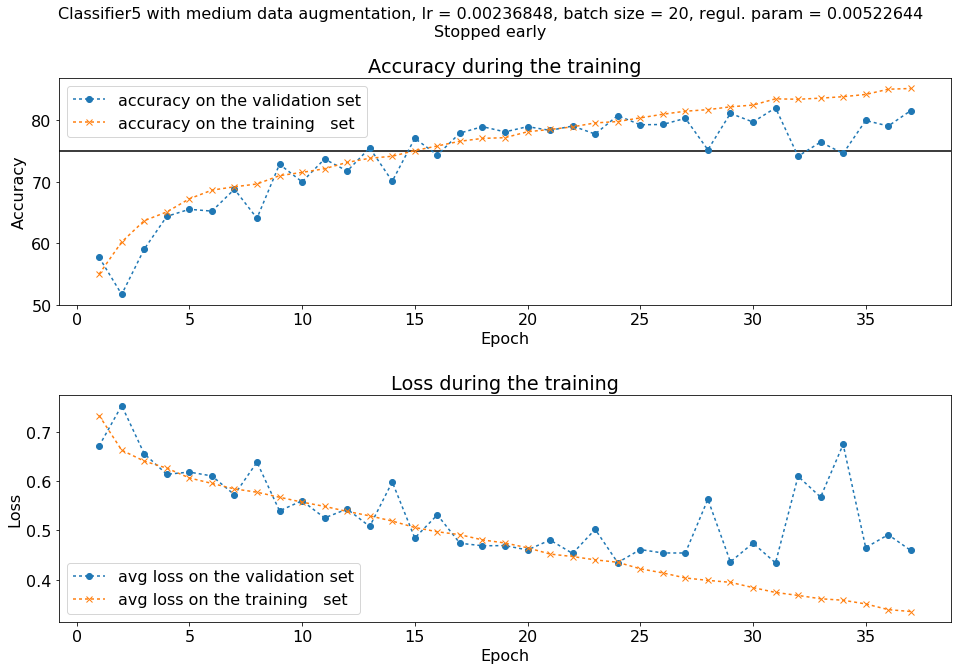

In [375]:
want_log     = True
early_stop   = 37
title        = "Classifier5 with medium data augmentation, lr = {lr}, batch size = {bs}, regul. param = {rp}".format(
                    lr=lr,
                    bs=train_batch_size,
                    rp=regularization
                ) + "\nStopped early"
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
plot_1d_acc_and_loss(net1, accuracy1[:early_stop,:], avg_loss1[:early_stop,:], path_to_save, filename, title, want_log)

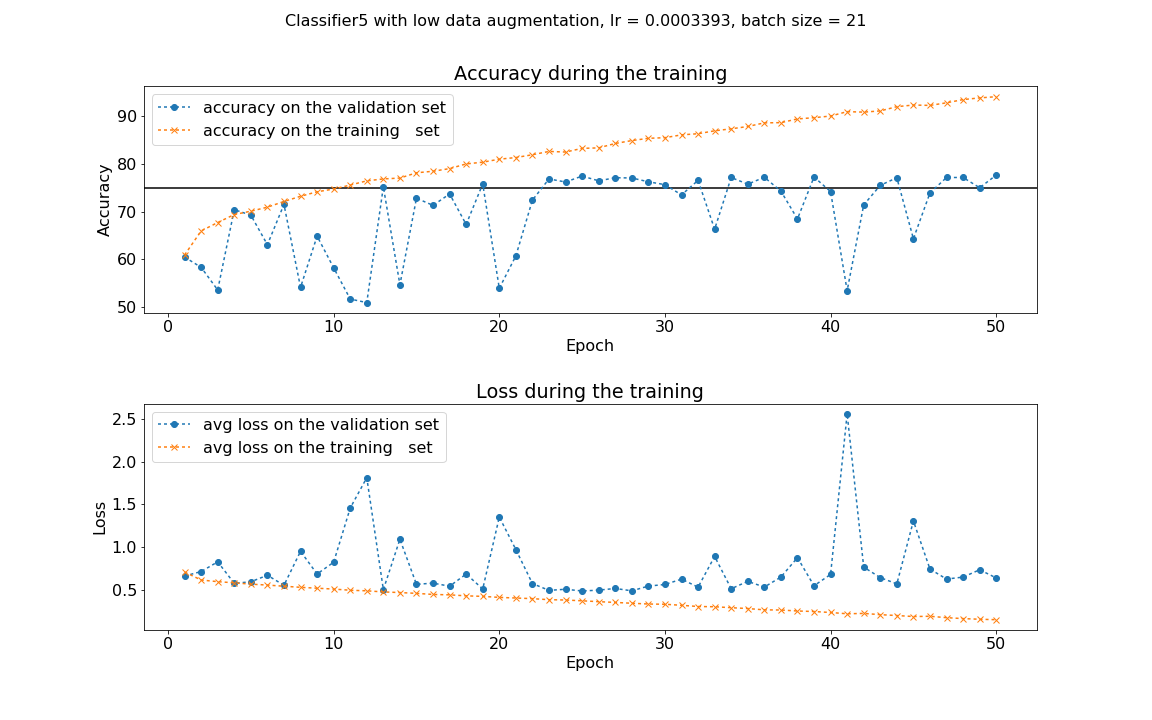

In [283]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February14_PM01H40M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

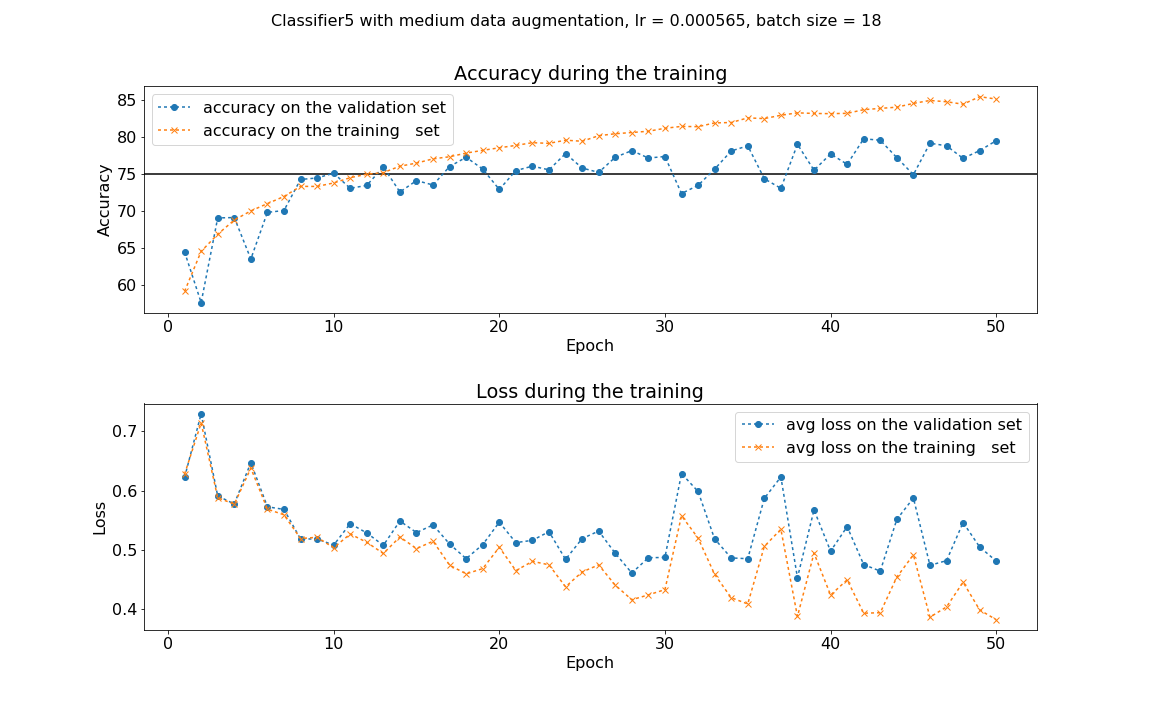

In [255]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February13_PM11H49M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

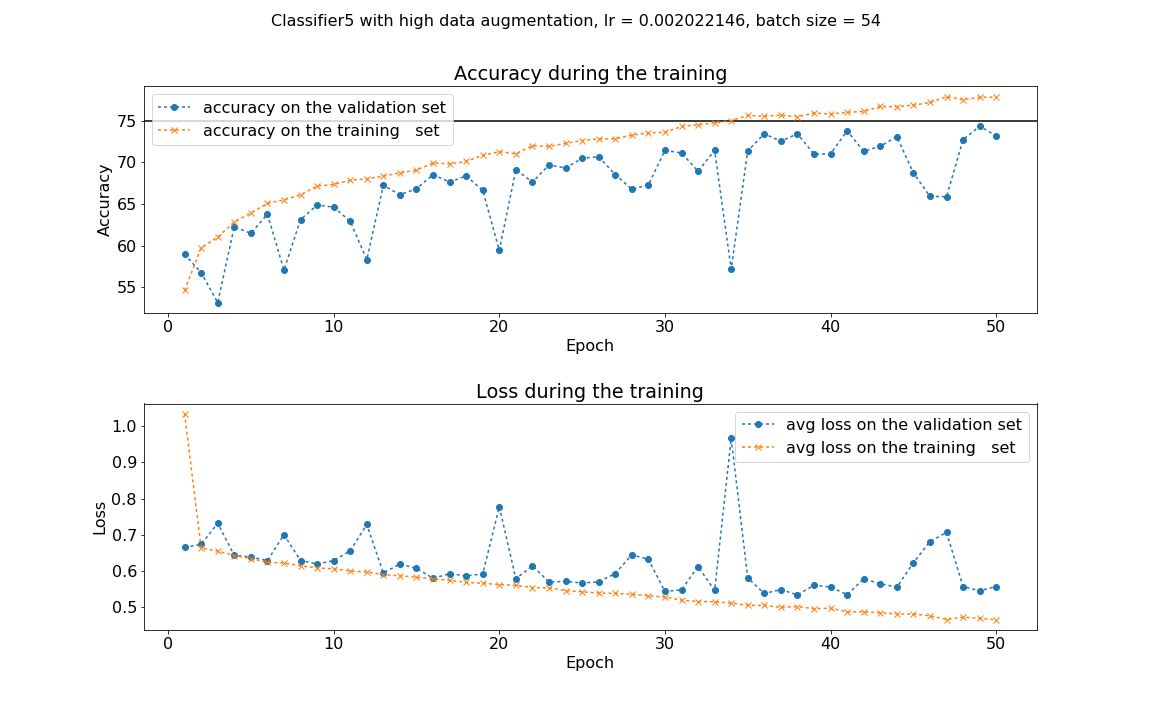

In [257]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February14_AM01H03M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

# Finding good hyper-parameters
#### What we plan to do :  
a) We generate a pair (learning rate, batch size)  
b) We train an net for k epoch using these hyper-parameters  
c) We pick the net that has the highest accuracy on the validation dataset  
d) Continue training this net with the same fixed hyper-parameters

#### How to search in the hyper-parameters space  
We don't want to use grid search because it amounts to search for too few point in each individual dimension. i.e. the cardinality of the projection of the points used in each dimension is significantly lower than the total number of points evaluated.   
We dont't want to use random search either because of its high discrepency.  
We use a low-discrepancy sequence instead. More specificaly successive points from a 2d sobol sequence.  
  
Here's what it looks like :  


In [330]:
class HyperParameterSequence():
    """
    2d Sobol sequence
    """
    def __init__(self,starting_point,nb_points,lr_interval,bs_interval):
        self.starting_point = starting_point
        self.nb_points      = nb_points
        self.lr_min         = lr_interval[0]
        self.lr_max         = lr_interval[1]
        self.bs_min         = bs_interval[0]
        self.bs_max         = bs_interval[1]
        
        self.seq = np.empty((nb_points,2))
        end = start + nb_points
        for i,j in enumerate(range(start,end,1)) :
            hyperparam_point ,_ = sobol_seq.i4_sobol(2,j)
            lr, batch_size      = hyperparam_point
            # take the point in the unitary cube and map it to the desired box
            lr         = lr*(self.lr_max-self.lr_min) +self.lr_min
            batch_size = batch_size*(self.bs_max-self.bs_min)+self.bs_min
            self.seq[i,:] = lr, batch_size
        
    def __len__(self):
        return self.nb_points

    def __getitem__(self, idx):
        return self.seq[idx]
    
    def get_sequence(self):
        return self.seq
    

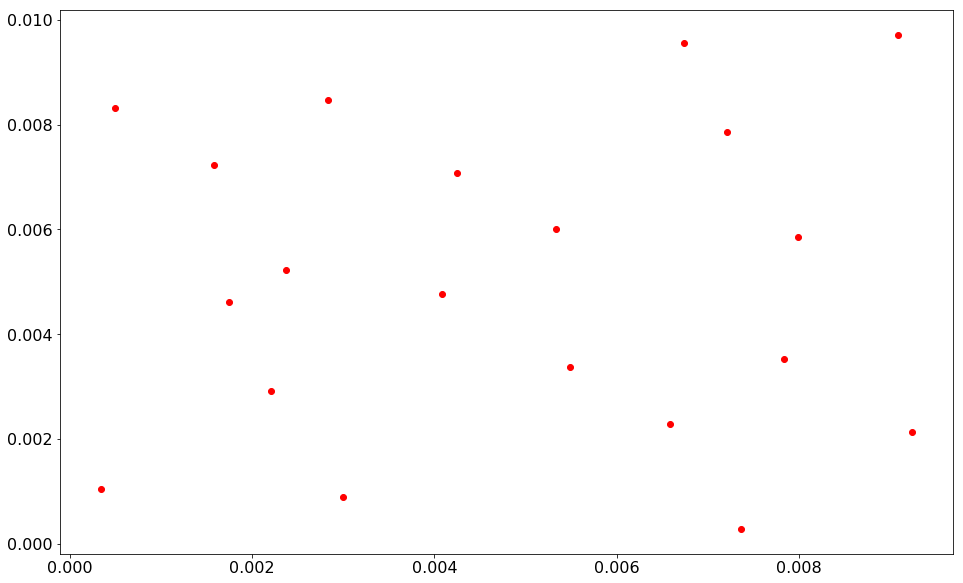

In [332]:
# Vizualize a 2d sobol sequence in the desired search box       
starting_point = 5030
nb_points      = 20
lr_interval    = [0.00001,0.01]
re_interval    = [0.0001,0.01]
# bs_interval    = [16,64]
hyper_param_sequence = HyperParameterSequence(starting_point,nb_points,lr_interval,re_interval)
seq = hyper_param_sequence.get_sequence()
plt.plot(seq[:,0],seq[:,1], 'ro')
plt.show()

#### A function that search the hyper-parameters space   
and returns the most promising combination.

In [333]:
nb_epoch  = 3

# current mlp with the best performance on the validation set, on its last epoch
acc_max = 0
idx_max = 0

# we save (all) the intermediate state of the model during the learning phase, for each mlp
state_dict_dict = dict() 
valid_batch_size = 16*64
valid_loader = DataLoader(train_dataset_norm, batch_size=valid_batch_size,sampler=valid_sampler, num_workers=num_workers)
for i, (lr, regul) in enumerate(hyper_param_sequence):      
    batch_size = math.ceil(batch_size) # cast to the correct type
    net_tmp = Classifier5() 
    net_tmp.apply( glorot_init )
    _ = net_tmp.to(device)
    
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.SGD(net_tmp.parameters(), lr=lr, momentum=0.0, weight_decay=0)
    
    batch_size       = 20
    train_batch_size = batch_size
    train_loader = DataLoader(train_dataset_augm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
    state_dict_list_tmp = list() # we save (all) the intermediate state of the model during the learning phase, for one  mlp

    # average loss across epoch
    avg_loss_tmp     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    # accuracy[i, 0 (resp. 1)] is the training (reps. validation) accuracy of the net at epoch i
    accuracy_tmp     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    
    # print hyper-parameters 
    print("point no. {i}, lr = {lr}, batch size = {batch_size}".format(i=i, lr=lr,batch_size=batch_size))
    
    # we dump output to disable sound
    torch.cuda.synchronize()
    _ = training_phase( net_tmp, nb_epoch, optimizer, regul, avg_loss_tmp, 
                           accuracy_tmp, train_loader, valid_loader, state_dict_list_tmp )
    state_dict_dict[i] = [[lr,batch_size],state_dict_list_tmp,avg_loss_tmp,accuracy_tmp]
    
    
    valid_accuracy = accuracy_tmp[-1,1] # last validation accuracy
    if valid_accuracy > acc_max :
        acc_max = valid_accuracy
        idx_max = i
    torch.cuda.synchronize()

print("#####################")
print("best net found : {i} , with validation accuracy = {va}".format(i=idx_max,va=acc_max.item()))
Audio(wave, rate=10000, autoplay=True)

point no. 0, lr = 0.00736347900390625, batch size = 20
0.0002764404296875 tensor(30.4248, device='cuda:0', grad_fn=<SqrtBackward>) tensor(1.5729, device='cuda:0', grad_fn=<AddBackward0>)
0.0002764404296875 tensor(30.4691, device='cuda:0', grad_fn=<SqrtBackward>) tensor(2217.9106, device='cuda:0', grad_fn=<AddBackward0>)
0.0002764404296875 tensor(139.8888, device='cuda:0', grad_fn=<SqrtBackward>) tensor(311.8046, device='cuda:0', grad_fn=<AddBackward0>)
epoch =   1, train loss = nan , train accuracy = 49.902771 , valid loss = nan , valid accuracy = 50.575287
epoch =   2, train loss = nan , train accuracy = 49.936108 , valid loss = nan , valid accuracy = 50.575287
epoch =   3, train loss = nan , train accuracy = 49.936108 , valid loss = nan , valid accuracy = 50.575287
Finished Training
Time required =  127.04896875  s 
point no. 1, lr = 0.00236847900390625, batch size = 20
0.005226440429687501 tensor(30.4376, device='cuda:0', grad_fn=<SqrtBackward>) tensor(1.0068, device='cuda:0', grad_

epoch =   2, train loss = 0.615641 , train accuracy = 66.309242 , valid loss = 0.607839 , valid accuracy = 66.983490
epoch =   3, train loss = 0.598068 , train accuracy = 67.937111 , valid loss = 0.616114 , valid accuracy = 65.732864
Finished Training
Time required =  124.8432890625  s 
point no. 10, lr = 0.00033926025390625006, batch size = 20
0.0010498779296875 tensor(30.4303, device='cuda:0', grad_fn=<SqrtBackward>) tensor(3.9448, device='cuda:0', grad_fn=<AddBackward0>)
0.0010498779296875 tensor(30.4300, device='cuda:0', grad_fn=<SqrtBackward>) tensor(14.2626, device='cuda:0', grad_fn=<AddBackward0>)
0.0010498779296875 tensor(30.4289, device='cuda:0', grad_fn=<SqrtBackward>) tensor(4.1547, device='cuda:0', grad_fn=<AddBackward0>)
epoch =   1, train loss = 0.683149 , train accuracy = 62.136784 , valid loss = 0.604455 , valid accuracy = 66.233116
epoch =   2, train loss = 0.605661 , train accuracy = 67.253738 , valid loss = 0.581255 , valid accuracy = 70.685341
epoch =   3, train los

0.0078561279296875 tensor(118.4852, device='cuda:0', grad_fn=<SqrtBackward>) tensor(8743.3135, device='cuda:0', grad_fn=<AddBackward0>)
epoch =   1, train loss = nan , train accuracy = 49.947220 , valid loss = nan , valid accuracy = 50.575287
epoch =   2, train loss = nan , train accuracy = 49.936108 , valid loss = nan , valid accuracy = 50.575287
epoch =   3, train loss = nan , train accuracy = 49.936108 , valid loss = nan , valid accuracy = 50.575287
Finished Training
Time required =  125.7089296875  s 
#####################
best net found : 15 , with validation accuracy = 72.58629608154297


In [351]:
# display coordinate value for
# [coord1,coord2],_,_,_ = state_dict_dict[idx_max]
seq = hyper_param_sequence.get_sequence()
print(seq[1])
print(seq[idx_max])

[0.00236848 0.00522644]
[0.00908051 0.00971238]


### Display the result of the search  
Big points are good, small points are bad.  
We scale the area of the points to make the results easily understandable.  

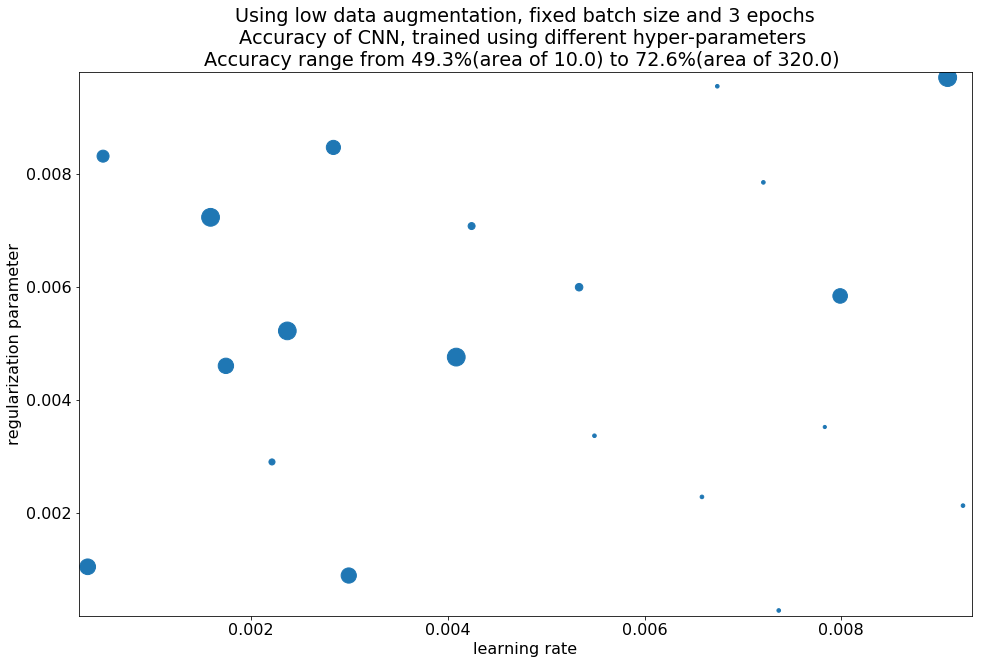

In [350]:
want_log     = True
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
title        = "Using low data augmentation, fixed batch size and 3 epochs"
axis_label   = ("learning rate","regularization parameter")
hyper_param  = hyper_param_sequence.get_sequence()   
N            = hyper_param_sequence.__len__()
_val = np.empty(N)
# retrieve previously measured accuracy 
for i in range(N):
    # [lr,batch_size],state_dict_list_tmp,avg_loss_tmp,accuracy_tmp
    _,_,_,acc = state_dict_dict[i]
    _val[i]   = acc[-1,1]
# retrieve the sequence used for the search    
     
plot_accuracy_2d(_val,hyper_param,path_to_save,filename,title,axis_label,want_log,scaling=(10,5))

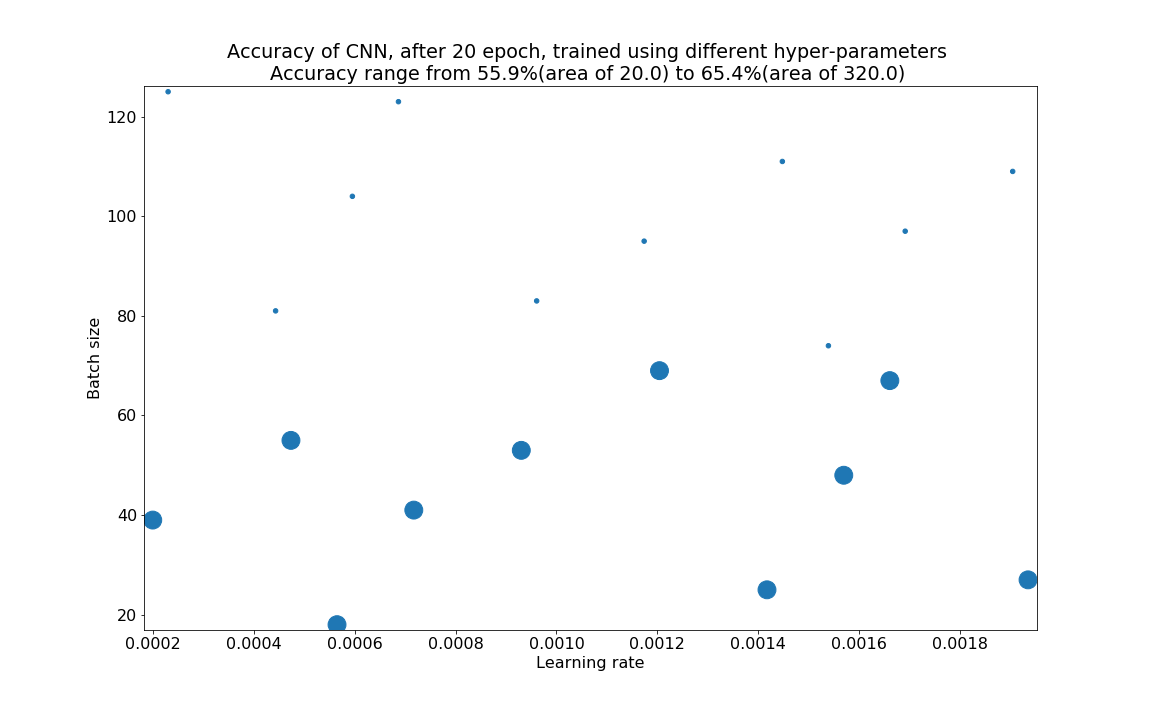

In [342]:
# Here's what we add when we runned the notebook with medium data augmentation :
# and :
# starting_point = 3030
# nb_points      = 20
# lr_interval    = [0.002,0.00005]
# bs_interval    = [16,2*64]
loading_path = "./output/2019February13_PM10H33M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

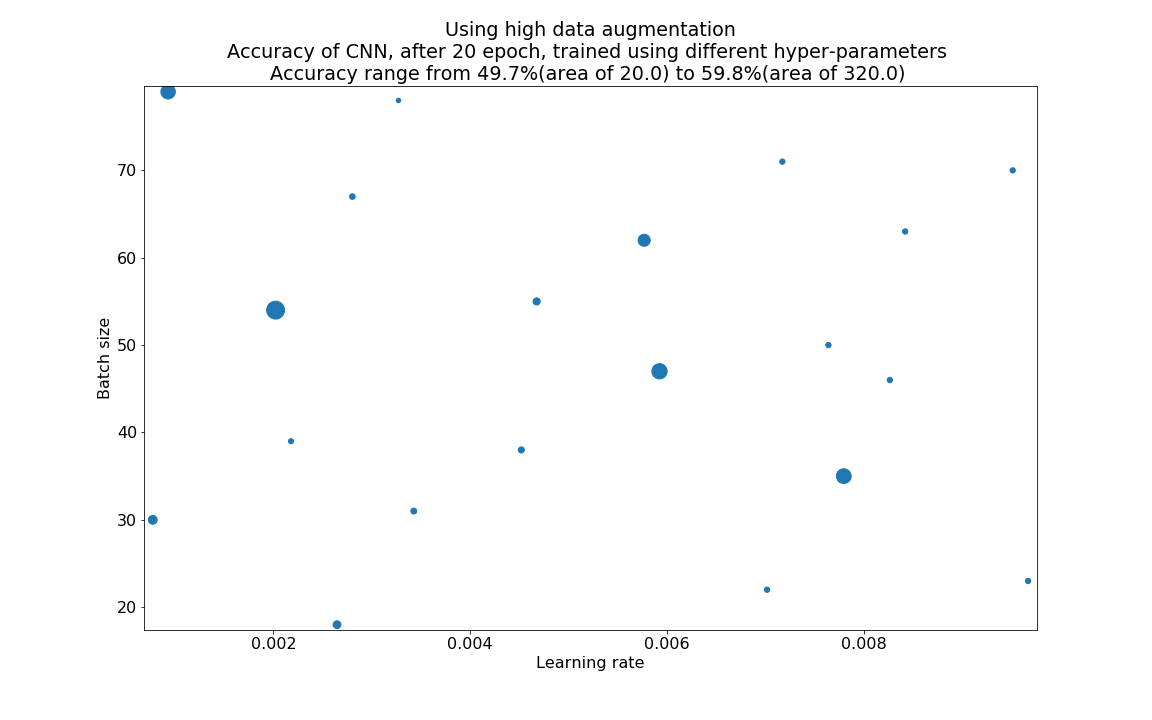

In [265]:
# Here's what we add when we runned the notebook with high data augmentation :
# and :
# starting_point = 4030
# nb_points      = 20
# lr_interval    = [0.01,0.00001]
# bs_interval    = [16,80]# Vizualize a 2d sobol sequence in the desired search box       
loading_path = "./output/2019February14_AM12H32M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

# Misc

#### print some test sample that the net misclassifies

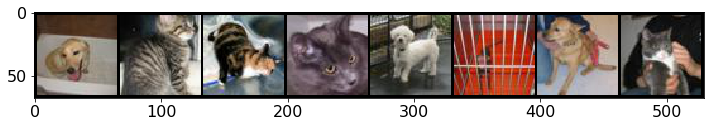

Probabilities goes from : 1 -> this is a dog for sure , to 0 -> cat for sure
this should be          :   1   , 0   , 0   , 0   , 1   , 1   , 1   , 0   
net associated prob     :   0.25, 0.82, 1.00, 0.79, 0.30, 0.13, 0.48, 0.97


In [92]:
batch_size = 8
valid_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

nb_of_error = torch.tensor([8])
j = torch.tensor([0])
errorimages  = torch.empty(8,3,64,64)
errorlabels  = torch.empty(8)
erroroutputs = torch.empty(8)
for images, labels in valid_loader :
    images, labels = images.to(device), labels.to(device)
    outputs = cuda_test_net(images).squeeze()
    # if using BCE
    # predicted = torch.where(outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) )
    # if using multi class cross entropy
    _, predicted = torch.max(outputs.data, 1)
    if not (predicted == labels).sum() == labels.size()[0] :
        comparison = (predicted == labels)
        for i,b in enumerate( comparison ) :
            if b == 0 :
                errorimages[j,:,:,:] = copy.deepcopy(images[i,:,:,:]).cpu()
                errorlabels[j] = labels[i].clone().detach().requires_grad_(False).cpu()
                erroroutputs[j] = outputs[i,1].clone().detach().requires_grad_(False).cpu()
                j = j + 1
                if j.item() >= nb_of_error.item() :
                    break
        else :
            continue
        break
        
if j.item() == 0 :
    print( "no error found")
else :
    imshow( torchvision.utils.make_grid(errorimages) )
    
    print( "Probabilities goes from : 1 -> this is a dog for sure , to 0 -> cat for sure")
    print( "this should be          : " , ",".join( " %-4d" % nb.item() for nb in errorlabels ) ) 
    print( "net associated prob     : " , ",".join( "%5.2f" % nb.item() for nb in erroroutputs ) ) 

Does stuff

In [310]:
for i,(name,layer) in enumerate(cudanet.named_parameters(),1) :
    print(i , "name : " , name , " : \n" , layer.size() )

1 name :  conv.0.weight  : 
 torch.Size([16, 3, 5, 5])
2 name :  conv.0.bias  : 
 torch.Size([16])
3 name :  conv.3.weight  : 
 torch.Size([32, 16, 5, 5])
4 name :  conv.3.bias  : 
 torch.Size([32])
5 name :  conv.6.weight  : 
 torch.Size([64, 32, 5, 5])
6 name :  conv.6.bias  : 
 torch.Size([64])
7 name :  conv.9.weight  : 
 torch.Size([128, 64, 5, 5])
8 name :  conv.9.bias  : 
 torch.Size([128])
9 name :  conv.11.weight  : 
 torch.Size([128, 128, 5, 5])
10 name :  conv.11.bias  : 
 torch.Size([128])
11 name :  conv.13.weight  : 
 torch.Size([256, 128, 3, 3])
12 name :  conv.13.bias  : 
 torch.Size([256])
13 name :  fct.weight  : 
 torch.Size([2, 16384])
14 name :  fct.bias  : 
 torch.Size([2])


#### Vizualize conv weigths

In [218]:
del net

In [81]:
# mynet = Classifier5()
# mynet.load_state_dict(net1.state_dict(),strict=False)

### Visualize feature maps

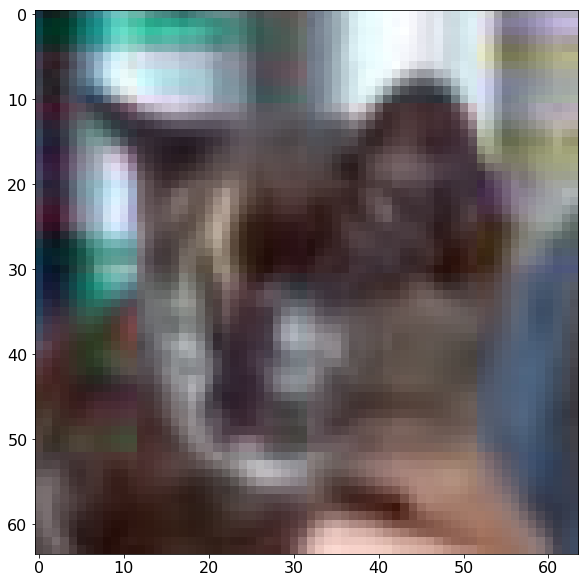

In [423]:
# display the sample picture used for vizualisation purpose
imshow(torchvision.utils.make_grid(sample_image))

layer :  0


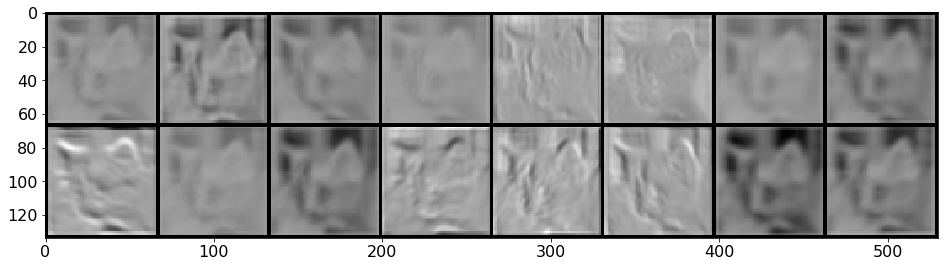

layer :  3


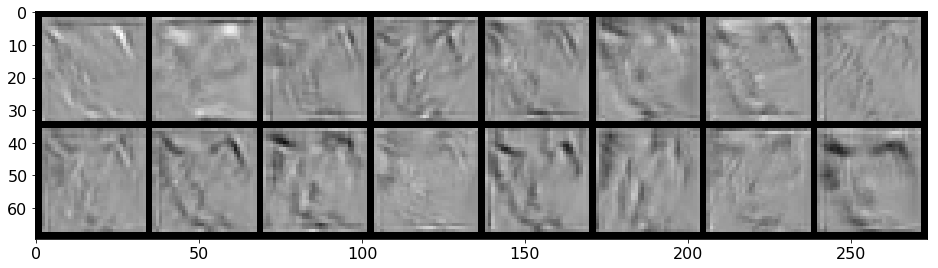

layer :  6


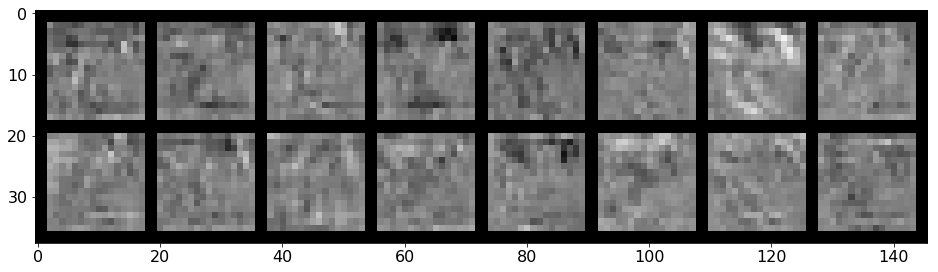

layer :  9


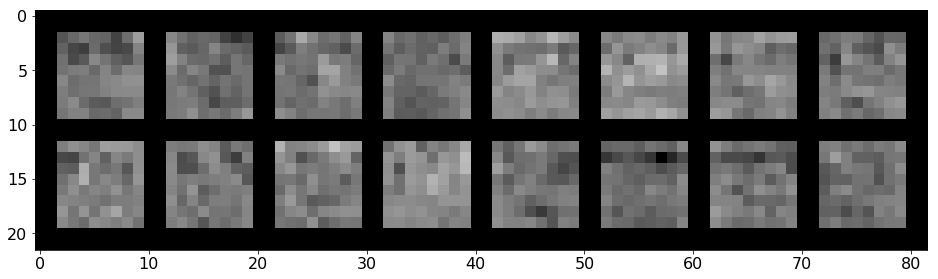

layer :  11


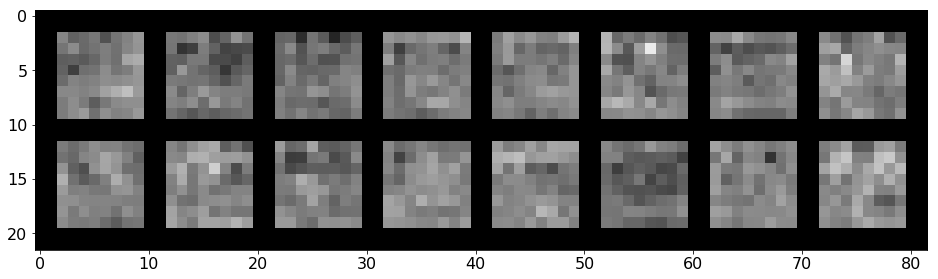

layer :  14


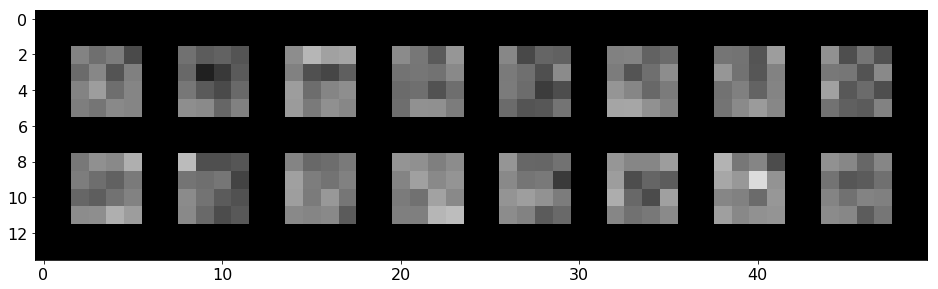

layer :  17


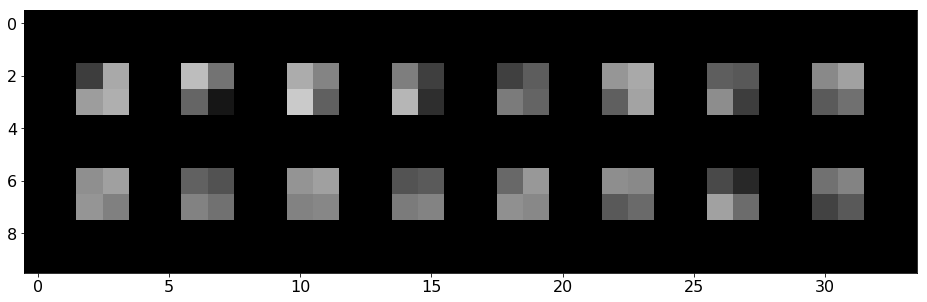

In [421]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# print which layers are convolutions
for number,layer in mynet.conv._modules.items():
    if  isinstance(layer,torch.nn.modules.conv.Conv2d) :
        print( "layer : " , number )
        
        layer = number # e.g. "3" : display all feature map of sample_image from layer "3"
        with torch.no_grad() :
            #print( net._modules )
            mynet.conv._modules[layer].register_forward_hook(get_activation(layer))
            output = mynet(sample_image.unsqueeze(0))

            act = activation[layer].squeeze().unsqueeze(1)
            # print(act.size())
            act = act - act.min()
            act = act / act.max() * 255
            size = min(act.size()[0],16)
        imshow(torchvision.utils.make_grid(act[:size,:,:,:] ))
        # print(act.max(),act.min())

### vizualize kernels, not useful

tensor(255.) tensor(0.)


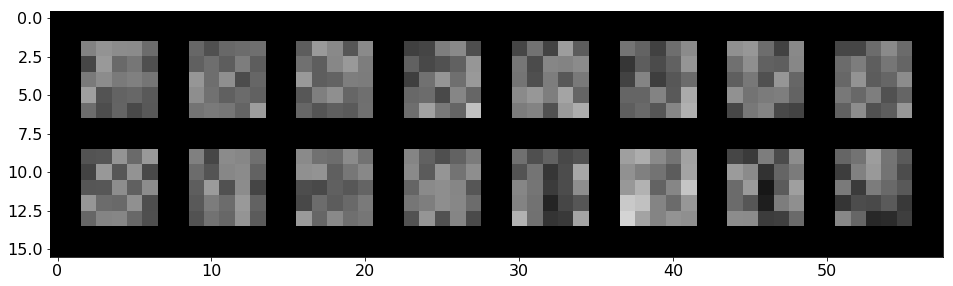

tensor(255.) tensor(0.)


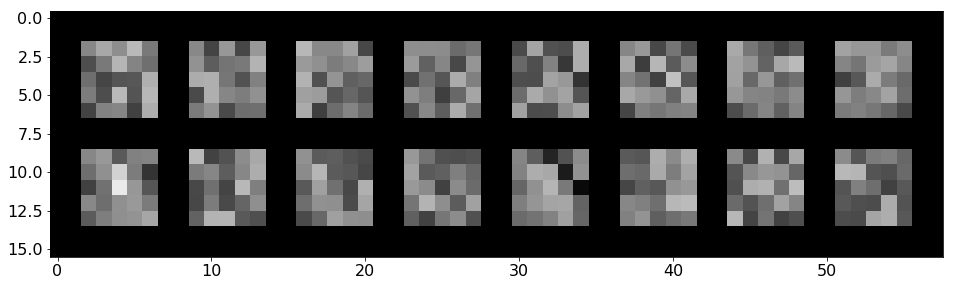

tensor(255.) tensor(0.)


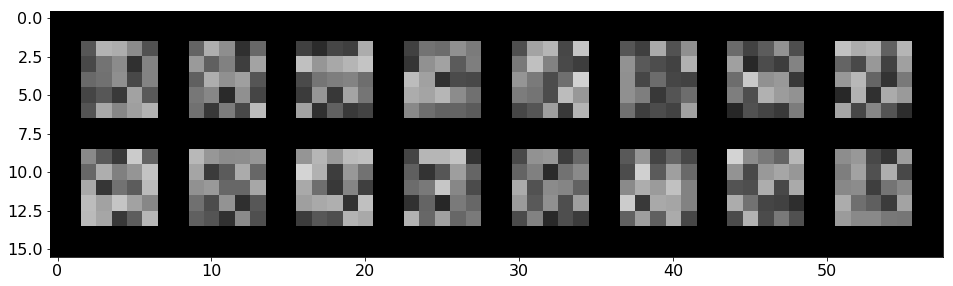

tensor(255.) tensor(0.)


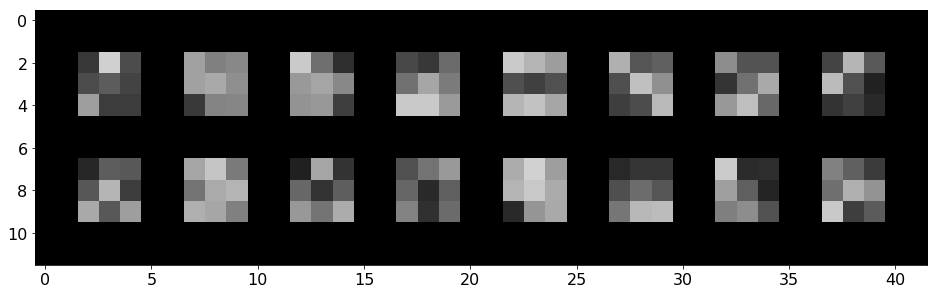

tensor(255.) tensor(0.)


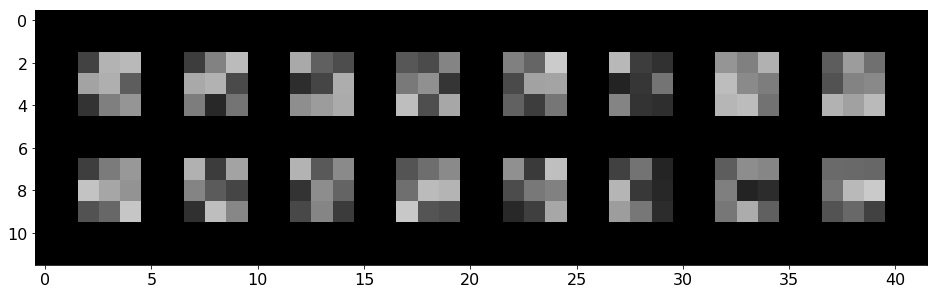

tensor(255.) tensor(0.)


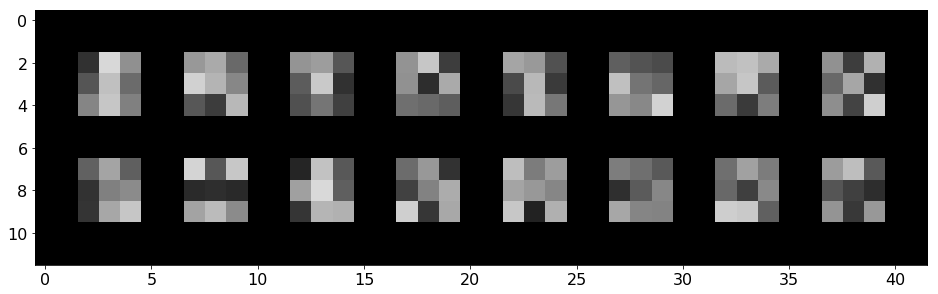

tensor(255.) tensor(0.)


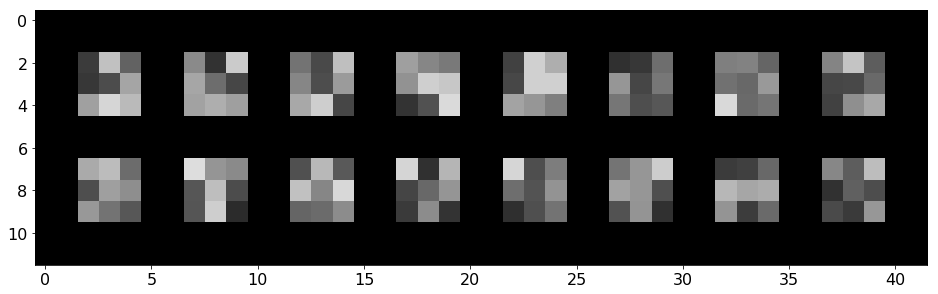

In [422]:
for i,(name, kernels) in enumerate(mynet.state_dict().items()) :
    if not (name.startswith("conv") and name.endswith("weight") ):
        continue 
    kernels = kernels.detach().view(-1,1,kernels.size()[-1],kernels.size()[-1])
    kernels = kernels - kernels.min()
    kernels = 255 * kernels / kernels.max() 
    size = min(kernels.size()[0],16)
    print( kernels.max() , kernels.min() )
    # print(kernels.size())
    imshow(torchvision.utils.make_grid(kernels[0:size,:,:,:]))

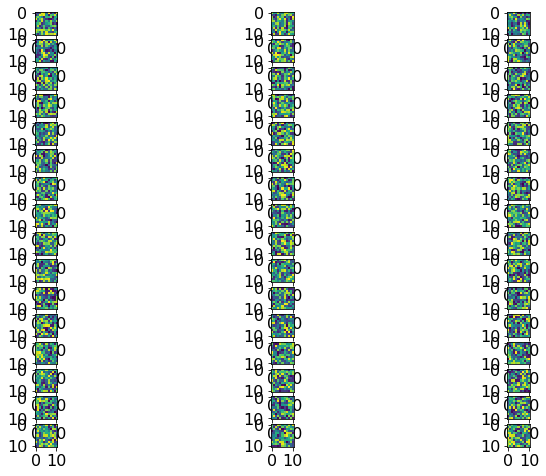

In [178]:

for i,(name, kernels) in enumerate(net.named_parameters()) :
    if i == 0 :
        kernels = kernels.detach()
        fig, axarr = plt.subplots(kernels.size(0),kernels.size(1))
        for idx in range(kernels.size(0)):
            for j in range(kernels.size(1)):
                axarr[idx,j].imshow(kernels[idx,j,:,:].squeeze())

conv.0.weight  =  [[ -7  -9  -5  11  10  -4  12 -11  -4 -11  10]
 [-11  -2  11   9  11   0 -11   5   3  10  -2]
 [  4   6   2  -1 -11   3   3   7 -12   0   2]
 [ 11  -3   5  10  -4  -9 -13 -12  -8   2  -8]
 [-11   2  -3  10  -8   3  -3   8  -1  -4   8]
 [  0   4   7 -10  -6   0   3   6 -11  -7 -13]
 [ -4   8 -11  -5   5  -4  -6   3   6   7  -4]
 [ -9   1  -4 -10   4  -9   4  -5 -11  -5 -10]
 [  9   7   9   9   8   4   8   1  11  -2  -7]
 [  8   4  -2   8  -5  10  -3  -6  -9   2   5]
 [  0 -10  -2   7   0  11   8   9   8  11  -5]]


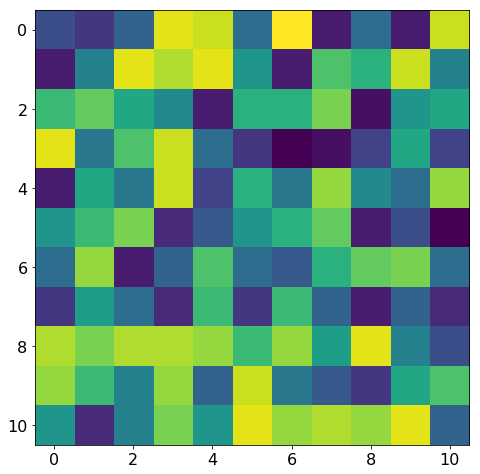

In [173]:
for layer, weight in cudanet.state_dict().items() :
    if layer.startswith("conv") and layer.endswith("weight") :
        tmp_weight = copy.deepcopy(weight.data).cpu().numpy() * 255
        tmp_weight = tmp_weight.astype(int)
        print(layer , " = " , tmp_weight[0,0,...])
        plt.imshow(tmp_weight[0,0,...])
        break
        

# Submit

a) We define a dataset for the test samples  
b) We load the test dataset, label all picture and produce a .csv file  

In [99]:
class nonlabeledDataSet(torch.utils.data.Dataset):

    def __init__(self , nb_of_sample, root_dir ):
        """
        Args:
            label is either "Cat" or "Dog"
            load in the dataset picture no. idx_min to idx_max included
            root_dir(string): directory with all images with the same label
        """
        # super(labeledDataSet, self).__init__()  
        self.root_dir = root_dir
        self.nb_of_sample = nb_of_sample
        self.load_data()
    
    def load_data(self) :
        size = self.__len__()
        
        self.data_tensor   = torch.empty(size,3,64,64,dtype=torch.float)
        
        for i in range(self.nb_of_sample) :
            j = i + 1
            img_path = self.root_dir +  "{index}.jpg".format(index=j)
            img = Image.open( img_path ).convert('RGB')
            image = torch.from_numpy( np.transpose( img , (-1,-3,-2) ) )
            image = image
            self.data_tensor[i,:,:,:] = image
        
    def __len__(self):
        return self.nb_of_sample

    def __getitem__(self, idx):
        return self.data_tensor[idx]


### Load a previously saved model is desired

In [74]:
loading_path = "./save/classifier1_201to500/dev1num3model_for_epoch300.pth" # Classifier1()
# loading_path = "./save/underfit201to300/dev1num3model_for_epoch100.pth" # Classifier5d()
# loading_path = "./save/classifier5wsm_nocrop_51to100/dev1num3model_for_epoch50.pth" # Classifier5()

cudanet_tocpu = Classifier1()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet2 = copy.deepcopy( cudanet_tocpu ).to(device)

In [75]:
criterion = nn.CrossEntropyLoss()
batch_size = 16*64
train_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
a,b = measure_single_accuracy_and_loss( cudanet2 , train_loader, criterion )
print(a.item(), "loss : " , b.item())
a,b = measure_single_accuracy_and_loss( cudanet2 , valid_loader, criterion )
print(a.item(), "loss : " , b.item())

80.22667694091797 loss :  0.49161943793296814
77.78889465332031 loss :  0.5254817605018616


In [111]:
# testset_dir = '/content/drive/My Drive/data_catdogs/testset/'
testset_dir        = "./data_catdogs/testset/test/"
batch_size         = 16*64
total_nb_of_sample = 4999 # total number of total unlabelled samples
test_dataset = nonlabeledDataSet(total_nb_of_sample,testset_dir)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=num_workers)

def class_from_index(ind):
    return train_dataset_norm.classes[ind]

remember_prediction = torch.empty(batch_size)
with open('submission3.csv', mode='w') as submission:
    submission.write('id,label\n')
    i = 1
    for query in test_loader:
        img = query
        with torch.no_grad():
            img          = img.to(device)
            outputs      = cudanet2(img).squeeze()
            # _, predicted = torch.max(outputs.data, 1)
            outputs = cudanet1(img)
            _, predicted1 = torch.max(outputs.data, 1)
            outputs = cudanet2(img)
            _, predicted2 = torch.max(outputs.data, 1)
            outputs = cudanet3(img)
            _, predicted3 = torch.max(outputs.data, 1)
            predicted , _ = torch.mode(torch.cat((predicted1.unsqueeze(1),predicted2.unsqueeze(1),predicted3.unsqueeze(1)),-1).squeeze(),-1)
    
            if i == 1 :
                remember_prediction = copy.deepcopy(predicted).cpu()
            for j in range(predicted.shape[0]) :
                idx    = predicted[j]
                label  = class_from_index(idx)
                submission.write('{},{}\n'.format(i,label) )
                i = i + 1

#### For sanity, manually check the first 100 pictures  

In [112]:
good_test_answers = torch.zeros(100,dtype=torch.long)
dog_idx = [2,4,6,7,8,14,16,17,19,20,22,24,26,29,31,32,39,41,43,45,53,58,61,
           63,69,70,71,74,75,76,77,82,83,84,86,87,89,93,94,97,98,99]
for i in dog_idx :
    good_test_answers[i-1] = 1
    
count = 0
prediction = remember_prediction[:100]
for i in range(100):
    if prediction[i] == good_test_answers[i] :
        count = count + 1
print("Number of good answer for first 100 samples : " , count) 

83
tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1])


#### For sanity, manually check that the loader loads the picture in the good order

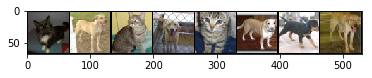

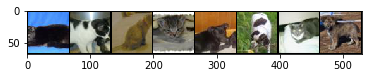

In [118]:
test_pict_loader  = DataLoader(test_dataset, batch_size=8,shuffle=False, num_workers=num_workers)
for i, img in enumerate(test_pict_loader):
    if i > 1 :
        break
    imshow(torchvision.utils.make_grid(img))

### Save and load models

In [378]:
# save current state only
# saving_path = "./save/export/dev1num3model.pth"
saving_path = "./save/export/dev1num3Classifier5_82.pth"
_ = mynet.cpu()
state_dict_to_disk = mynet.state_dict()
torch.save( state_dict_to_disk , saving_path )
_ = mynet.to(device)

In [106]:
# load one state

# loading_path = "./save/classifier1_201to500/dev1num3model_for_epoch300.pth" # Classifier1()
# loading_path = "./save/underfit201to300/dev1num3model_for_epoch100.pth" # Classifier5()
# loading_path = "./save/classifier1b_1to30\dev1num3model_for_epoch30.pth" # Classifier1b()
# loading_path = "./save/classifier1_150to200/dev1num3model_for_epoch50.pth" # Classifier1()

# loading_path = "./save/dev1num3model.pth"
# cudanet_tocpu = Classifier1()
# cudanet_tocpu = Classifier5()
# cudanet_tocpu = Classifier1b()
# cudanet_tocpu = Classifier1()
# cudanet_tocpu.load_state_dict(torch.load(loading_path))
# cudanet4 = copy.deepcopy( cudanet_tocpu ).to(device)

loading_path = "./save/classifier1_201to500/dev1num3model_for_epoch300.pth" # Classifier1()
cudanet_tocpu = Classifier1()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet1 = copy.deepcopy( cudanet_tocpu ).to(device)

loading_path = "./save/underfit201to300/dev1num3model_for_epoch100.pth" # Classifier5()
cudanet_tocpu = Classifier5d()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet2 = copy.deepcopy( cudanet_tocpu ).to(device)

# cudanet3 = copy.deepcopy(cudanet)
# loading_path = "./save/classifier1b_1to30\dev1num3model_for_epoch30.pth" # Classifier1b()
# cudanet_tocpu = Classifier1b()
# cudanet_tocpu.load_state_dict(torch.load(loading_path))
# cudanet3 = copy.deepcopy( cudanet_tocpu ).to(device)

loading_path = "./save/classifier5wsm_nocrop_100to151/dev1num3model_for_epoch50.pth" # Classifier5()
cudanet_tocpu = Classifier5()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet3 = copy.deepcopy( cudanet_tocpu ).to(device)

#### Save the state_dict of the model for each epoch on a local directory

In [217]:
local_path = "./save"
for epoch , tmp_state_dict in enumerate(state_dict_list,1) :
    saving_path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    torch.save( tmp_state_dict , saving_path)
    # print( saving_path )

#### load from file and set the load the state_dict of the last epoch on a object
the files have to be located in "./save" and named "dev1num3model_for_epoch{j}.pth" for j from ... to ...

In [107]:
local_path = "./save"
state_dict_list = list()

from_idx = 1
to_idx   = nb_epoch

for epoch in range( from_idx  , to_idx + 1 , 1 ):
    path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    tmp_dict = torch.load(path)
    state_dict_list.append(tmp_dict)
    # print( path )
else : 
    cudanet = Classifier6( )
    cudanet.load_state_dict(tmp_dict)
    cudanet.to(device)
    cudanet.eval()                     

### Other stuff  
see some models :  
https://pytorch.org/docs/stable/torchvision/models.html

### Find a good initialization  
The following code is usefull to find a good initialization if finding one requires multiple try  
It works as follow :  
Try different random init, train them for 3 epoch, repeat until you find one than has learnt something

In [ ]:
# del cudanet 
nb_epoch  = 1
nb_try    = 3
batch_size = 1*16
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)

state_dict_list = list()

torch.cuda.synchronize()

start = torch.cuda.Event(enable_timing=True)
end   = torch.cuda.Event(enable_timing=True)
start.record()

for trial in range(nb_try) :
    cudanet = Classifier5()
    # cudanet = Classifier1b(sigmoid=True)
    cudanet.apply( glorot_init )
    _ = cudanet.to(device)
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(cudanet.parameters(), lr=0.00025, momentum=0, weight_decay=0)
    optimizer = optim.SGD(cudanet.parameters(), lr=0.0001, momentum=0, weight_decay=0)
    correct = torch.tensor([0])
    total = torch.tensor([0])
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times 

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # if using BCE :
            # labels = labels.float() 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cudanet(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            with torch.no_grad() :
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
        else : # print every epoch
            print('trial %d , epoch = %d, loss = %.8f' % (trial + 1, epoch + 1, running_loss / training_dataset_size)) # nb of sample per mini-batch
            running_loss = 0.0
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in cudanet.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()
    accuracy = 100*correct.double()/total.double()
    print("Accuracy for trial %d : %.4f %%" % (trial+1 , accuracy) )
    if accuracy > 53 :
        print('Successful search')
        break
    del cudanet
else : 
    print('Unsuccessful search')
    
end.record()
torch.cuda.synchronize()

print( "time required = " , start.elapsed_time(end)*0.001 , " s ")
Audio(wave, rate=10000, autoplay=True)

### Use majority vote  
Use and odd number of net to find what they each think of a picture and take the majority vote among them.  
This is usefull to see if multiple nets "are independant sources of information" or if "they all learnt the same things"  

In [ ]:
batch_size = 4*64
validation_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
# validation_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

majority_by_confidence = True

correct = torch.tensor([0])
total = torch.tensor([0])
   
correct, total = correct.to(device) , total.to(device) 
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # if using BCE
        # labels = labels.float()
        images, labels = images.to(device), labels.to(device)
        
        if majority_by_confidence :
            outputs =  cudanet1(images) + cudanet2(images) + cudanet3(images) 
            _, predicted = torch.max(outputs.data, 1)
        else :
            outputs = cudanet1(images)
            _, predicted1 = torch.max(outputs.data, 1)
            outputs = cudanet2(images)
            _, predicted2 = torch.max(outputs.data, 1)
            outputs = cudanet3(images)
            _, predicted3 = torch.max(outputs.data, 1)
            predicted , _ = torch.mode(torch.cat((predicted1.unsqueeze(1),predicted2.unsqueeze(1),predicted3.unsqueeze(1)),-1).squeeze(),-1)
        # print(predicted1.shape)
        # print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the' , total.item() , 'test images: %.2f %%' 
          % ( (100 * correct.double()) / total.double()  )
     ) 

dense net as in :  
https://pytorch.org/docs/stable/_modules/torchvision/models/densenet.html#densenet121

In [ ]:
# test to import greyscale with transforms.ToTensor()


In [ ]:
# check if there is an image of size 80
pict_a_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=1, sampler=valid_sampler, num_workers=num_workers)
for i, (images, labels) in enumerate(pict_a_loader) :
    if images.size()[3] == 80 :
        imshow(torchvision.utils.make_grid(images))
        break

In [28]:
with torch.no_grad() :
    A = torch.ones(5,5) + torch.transpose(torch.tensor([[1,2,3,4,5]],dtype=torch.float),1,0)
    xx = torch.ones(3,5,5)
    print(A)
    xx = torch.matmul(A, xx) 
    print( xx )
    xx = xx.view(-1,5*5)
    print(xx)
    

tensor([[2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6.]])
tensor([[[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]],

        [[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]],

        [[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]]])
tensor([[10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 20., 20., 20., 20.,
         20., 25., 25., 25., 25., 25., 30., 30., 30., 30., 30.],
        [10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 20., 20., 20., 20.,
         20., 25., 25., 25., 25., 25., 30., 30., 30., 30., 30.],
        [10., 1

#### Deprecated

In [84]:
total_nb_of_sample = 4999 # total number of sample per class, this shouldn't be hardcoded
class labeledDataSet(torch.utils.data.Dataset):

    def __init__(self, label, idx_min , idx_max , root_dir ):
        """
        Args:
            label is either "Cat" or "Dog"
            load in the dataset picture no. idx_min to idx_max included
            root_dir(string): directory with all images with the same label
        """
        # super(labeledDataSet, self).__init__()
        dic = {"Cat" : int(1) , "Dog" : int(0)}
        
        if dic.get(label , "not found" ) == "not found" :
            raise ValueError("label must either be Cat or Dog")
            
        if idx_max > total_nb_of_sample or idx_min < 0 :
            raise ValueError("min, max index error")
            
        self.label_name = label
        self.idx_min = idx_min
        self.idx_max = idx_max
        self.label = dic[label]
        self.root_dir = root_dir
        self.load_data()
    
    def load_data(self) :
        size = self.__len__()
        
        self.data_tensor = torch.empty(size,3,64,64,dtype=torch.float)
        self.target_tensor = torch.ones(size,dtype=torch.long) * self.label
        
        for i,j in enumerate(range( self.idx_min , self.idx_max , 1 ),0) :
            img_path = self.root_dir +  "/{index}.{Label}.jpg".format(index=(j),Label=self.label_name)
            # image = io.imread(img_name)
            # print( i , " : " , io.imread(img_name).shape )
            # img = io.imread(img_name)
            # print( img_path )
            img = Image.open( img_path ).convert('RGB')
            """
            NOTE : There is at least one grey-scale picture of Einstein, manually remove it ?
            the greyscale (1 channel) images have to be converted to 3 channels tensors
            """   
            image = torch.from_numpy( np.transpose( img , (-1,-3,-2) ) )
            self.data_tensor[i,:,:,:] = image
        
    def __len__(self):
        # return len(self.name_frame)
        return (self.idx_max - self.idx_min + 1)

    def __getitem__(self, idx):
        return self.data_tensor[idx], self.target_tensor[idx]


In [ ]:
# picture no 1             to (idx_sep)            belong to the training dataset
# picture no (idx_sep + 1) to (total_nb_of_sample) belong to the validation dataset
idx_sep = 8000

trainDogSet = labeledDataSet( "Dog", 1 , idx_sep , root_dir = dog_dir )
trainCatSet = labeledDataSet( "Cat", 1 , idx_sep , root_dir = cat_dir )

testsDogSet = labeledDataSet( "Dog", idx_sep + 1 , total_nb_of_sample , root_dir = dog_dir )
testsCatSet = labeledDataSet( "Cat", idx_sep + 1 , total_nb_of_sample , root_dir = cat_dir )
dog_dir = "./data_catdogs/trainset/Dog"
cat_dir = "./data_catdogs/trainset/Cat"

# picture no 1             to (idx_sep)            belong to the training dataset
# picture no (idx_sep + 1) to (total_nb_of_sample) belong to the validation dataset
idx_sep = 8000

trainDogSet = labeledDataSet( "Dog", 1 , idx_sep , root_dir = dog_dir )
trainCatSet = labeledDataSet( "Cat", 1 , idx_sep , root_dir = cat_dir )

testsDogSet = labeledDataSet( "Dog", idx_sep + 1 , total_nb_of_sample , root_dir = dog_dir )
testsCatSet = labeledDataSet( "Cat", idx_sep + 1 , total_nb_of_sample , root_dir = cat_dir )

trainset = torch.utils.data.ConcatDataset( [ trainDogSet , trainCatSet ] )
testsset = torch.utils.data.ConcatDataset( [ testsDogSet , testsCatSet ] )

( "img size = " , img.size() , "label size = " , label.size() )
testing_dataset_size  = testsCatSet.__len__() + testsDogSet.__len__()
training_dataset_size = trainCatSet.__len__() + trainDogSet.__len__()

print( "training dataset size = " , training_dataset_size ) 
print( "testing  dataset size = " , testing_dataset_size ) 
print( trainDogSet.__doc__ ) 
img, label =  trainDogSet.__getitem__(1)
print( "img size = " , img.size() , "label size = " , label.size() )